In [1]:
# Import packages
import plotly.express as px
import pandas as pd

# Read in the data
data = pd.read_csv('../coal-price-data/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])


def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

In [2]:
# Import packages
from scipy.stats import boxcox

# Make the target stationary
data['Passengers_boxcox'], lam = boxcox(data['#Passengers'])
data["Passenger_stationary"] = data["Passengers_boxcox"].diff()
data.dropna(inplace=True)

# Plot the stationary airline passenger data
plot_passenger_volumes(df=data, y='Passenger_stationary')

In [3]:
# Import packages
from statsmodels.tsa.stattools import adfuller

# ADF test for stationary
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for threshold, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (threshold, adf_stat))


print(adf_test(data["Passenger_stationary"]))

ADF Statistic:  -2.871707452081052
P-Value:  0.04873834333618049
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58
None


In [7]:
data

Month  #Passengers  Passengers_boxcox  Passenger_stationary
1   1949-02-01          118           6.932821              0.105332
2   1949-03-01          132           7.161890              0.229069
3   1949-04-01          129           7.114609             -0.047281
4   1949-05-01          121           6.983785             -0.130824
5   1949-06-01          135           7.208264              0.224478
..         ...          ...                ...                   ...
139 1960-08-01          606          10.684046             -0.067404
140 1960-09-01          508          10.234570             -0.449476
141 1960-10-01          461           9.992156             -0.242414
142 1960-11-01          390           9.582620             -0.409536
143 1960-12-01          432           9.831858              0.249238

[143 rows x 4 columns]

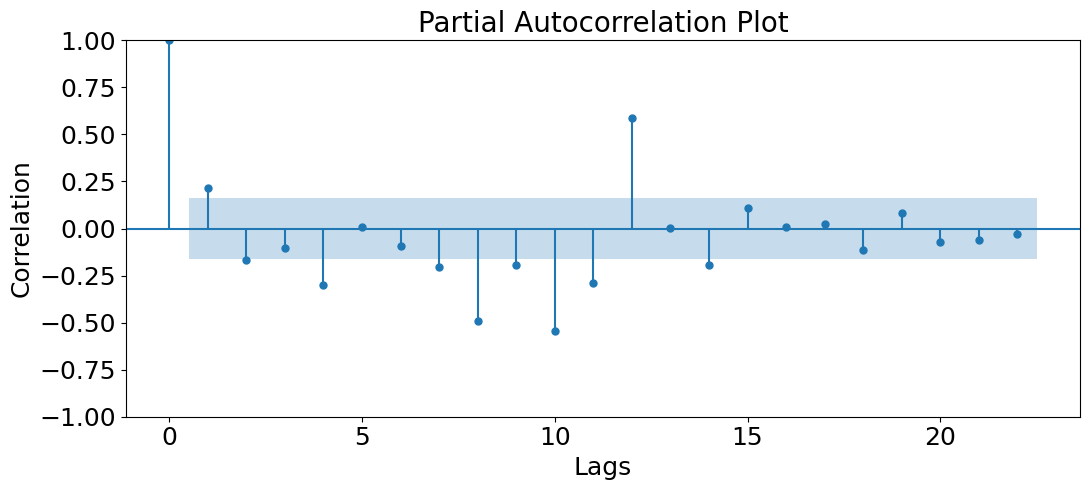

In [4]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['Passenger_stationary'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [5]:
# Import packages
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build AR model
selector = ar_select_order(train['Passenger_stationary'], 15)
model = AutoReg(train['Passenger_stationary'], lags=selector.ar_lags).fit()

/home/ibnu/miniconda3/envs/py311-kfp240-airflow251/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ibnu/miniconda3/envs/py311-kfp240-airflow251/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/home/ibnu/miniconda3/envs/py311-kfp240-airflow251/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [6]:
# Import packages
from scipy.special import inv_boxcox
import plotly.graph_objects as go

# Get forecasts and convert to actual passenger volumes
transformed_forecasts = list(model.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_boxcox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

/home/ibnu/miniconda3/envs/py311-kfp240-airflow251/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/ibnu/miniconda3/envs/py311-kfp240-airflow251/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

